In [1]:
from random import randint
import datetime

from sqlalchemy.engine import create_engine
from sqlalchemy.schema import (
    MetaData,
    Table,
    Column,
    ForeignKey,
)
from sqlalchemy.sql import insert, text as sql_text
from sqlalchemy.types import Integer, BigInteger, Date, String

import numpy as np
import matplotlib.pyplot as plt

In [2]:
engine = create_engine("sqlite+pysqlite:///:memory:", future=True)
conn = engine.connect()
metadata = MetaData()

In [3]:
def create_tables():
    filials = Table(
        'lab_filial',
        metadata,
        Column('id', Integer, primary_key=True, autoincrement=True),
        Column('name', String(50))
    )
    products = Table(
        'lab_product',
        metadata,
        Column('id', Integer, primary_key=True, autoincrement=True),
        Column('name', String(100))
    )
    reports = Table(
        'lab_report',
        metadata,
        Column('id', Integer, primary_key=True, autoincrement=True),
        Column('id_filial', BigInteger, ForeignKey('lab_filial.id')),
        Column('id_part', BigInteger, ForeignKey('lab_product.id')),
        Column('date', Date),
        Column('part_count', BigInteger)
    )
    return filials, products, reports

In [4]:
def make_fake_filials(filials):
     return insert(filials).values([
        {'name': 'Facebook'},
        {'name': 'Amazon'},
        {'name': 'Apple'},
        {'name': 'Netflix'},
        {'name': 'Google'},
    ])

def make_fake_products(products):
    return insert(products).values([
        {'name': 'iPhone'},
        {'name': 'iPad'},
        {'name': 'Ad banner'},
        {'name': 'Personal info'},
        {'name': 'Book'},
        {'name': 'Subscription'},
        {'name': 'Film'},
        {'name': 'Patent'},
        {'name': 'Cloud'},
    ])

def make_fake_reports(reports):
    # filials_count x products_count (5 x 9)
    relations = [
        [0, 0, 10, 20, 0, 0,  0,  5,  1],
        [1, 0, 3,  1,  5, 1,  1,  3,  15],
        [5, 3, 0,  1,  1, 2,  1,  10, 3],
        [0, 0, 2,  0,  1, 10, 10, 3,  0],
        [0, 0, 15, 5,  0, 2,  0,  10, 10],
    ]
    report_dict = lambda idf, idp, c, d: {'id_filial': idf, 'id_part': idp, 'part_count': c, 'date': d}
    min_mult, max_mult = 5, 8
    today = datetime.date.today()
    fake_reports = [
        report_dict(
            fil_id + 1,  # autoinc start from 1, range and index start from 0
            prod_id + 1,  # autoinc start from 1, range and index start from 0
            randint(relations[fil_id][prod_id] * min_mult, relations[fil_id][prod_id] * max_mult),
            today - datetime.timedelta(day)
        )
        for fil_id in range(5)
        for prod_id in range(9)
        for day in range(30)
        if relations[fil_id][prod_id] > 0
    ]
    return insert(reports).values(fake_reports)

In [5]:
filials, products, reports = create_tables()
metadata.create_all(engine)

In [6]:
_ = conn.execute(make_fake_filials(filials))
_ = conn.execute(make_fake_products(products))
_ = conn.execute(make_fake_reports(reports))

In [7]:
GET_REPORT_DATA_TEMPLATE = '''
SELECT
    filial.name AS filial,
    product.name AS product,
    report.date AS date,
    report.part_count AS count

      FROM lab_report  AS report
INNER JOIN lab_filial  AS filial  ON report.id_filial = filial.id
INNER JOIN lab_product AS product ON report.id_part = product.id

WHERE report.date > '{older_date}'

ORDER BY report.date DESC
'''
older_date = datetime.date.today() - datetime.timedelta(7)
query = sql_text(GET_REPORT_DATA_TEMPLATE.format(older_date=older_date))

In [8]:
result = conn.execute(query).fetchall()
print(result)

[('Facebook', 'Ad banner', '2021-06-09', 57),
 ('Facebook', 'Personal info', '2021-06-09', 121),
 ('Facebook', 'Patent', '2021-06-09', 40),
 ('Facebook', 'Cloud', '2021-06-09', 7),
 ('Amazon', 'iPhone', '2021-06-09', 6),
 ('Amazon', 'Ad banner', '2021-06-09', 15),
 ('Amazon', 'Personal info', '2021-06-09', 8),
 ('Amazon', 'Book', '2021-06-09', 29),
 ('Amazon', 'Subscription', '2021-06-09', 7),
 ('Amazon', 'Film', '2021-06-09', 6),
 ('Amazon', 'Patent', '2021-06-09', 21),
 ('Amazon', 'Cloud', '2021-06-09', 120),
 ('Apple', 'iPhone', '2021-06-09', 30),
 ('Apple', 'iPad', '2021-06-09', 18),
 ('Apple', 'Personal info', '2021-06-09', 5),
 ('Apple', 'Book', '2021-06-09', 5),
 ('Apple', 'Subscription', '2021-06-09', 10),
 ('Apple', 'Film', '2021-06-09', 7),
 ('Apple', 'Patent', '2021-06-09', 58),
 ('Apple', 'Cloud', '2021-06-09', 22),
 ('Netflix', 'Ad banner', '2021-06-09', 15),
 ('Netflix', 'Book', '2021-06-09', 8),
 ('Netflix', 'Subscription', '2021-06-09', 77),
 ('Netflix', 'Film', '2021-0

In [9]:
filials = list({row[0] for row in result})
products = list({row[1] for row in result})

summary_count = {
    filial: {
        product: 0
        for product in products
    }
    for filial in filials
}

for row in result:
    summary_count[row[0]][row[1]] += row[3]

In [10]:
print(summary_count)

{'Facebook': {'iPhone': 0,
  'Film': 0,
  'Personal info': 867,
  'Book': 0,
  'Cloud': 45,
  'iPad': 0,
  'Ad banner': 414,
  'Patent': 240,
  'Subscription': 0},
 'Amazon': {'iPhone': 48,
  'Film': 47,
  'Personal info': 41,
  'Book': 232,
  'Cloud': 727,
  'iPad': 0,
  'Ad banner': 122,
  'Patent': 136,
  'Subscription': 46},
 'Apple': {'iPhone': 245,
  'Film': 43,
  'Personal info': 42,
  'Book': 47,
  'Cloud': 148,
  'iPad': 136,
  'Ad banner': 0,
  'Patent': 415,
  'Subscription': 92},
 'Google': {'iPhone': 0,
  'Film': 0,
  'Personal info': 213,
  'Book': 0,
  'Cloud': 478,
  'iPad': 0,
  'Ad banner': 720,
  'Patent': 433,
  'Subscription': 89},
 'Netflix': {'iPhone': 0,
  'Film': 502,
  'Personal info': 0,
  'Book': 43,
  'Cloud': 0,
  'iPad': 0,
  'Ad banner': 91,
  'Patent': 144,
  'Subscription': 454}}

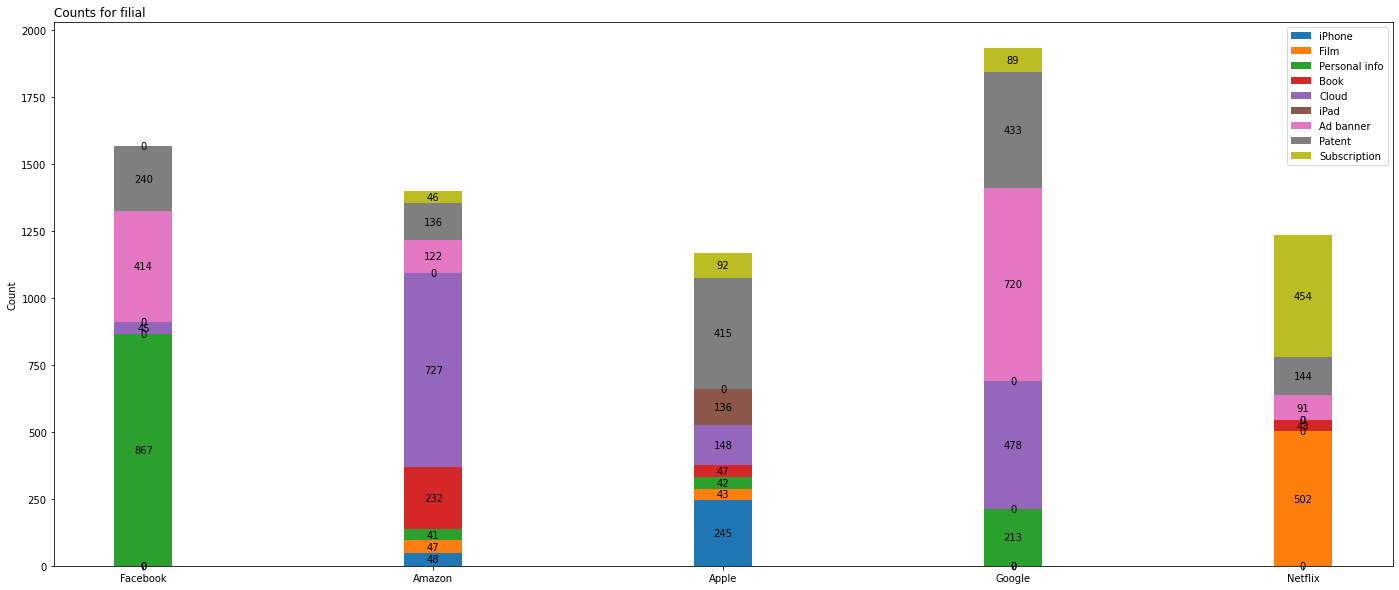

In [11]:
fig, ax = plt.subplots(figsize=(24, 10))
ax.set_ylabel('Count')
ax.set_title('Counts for filial', loc='left')

sum_products = [0] * len(filials)

for product in products:
    product_counts = [summary_count[filial][product] for filial in filials]
    bar = ax.bar(filials, product_counts, 0.2, bottom=sum_products, label=product)
    ax.bar_label(bar, label_type='center')
    sum_products = [curr + add for (curr, add) in zip(sum_products, product_counts)]

ax.legend()
plt.show()

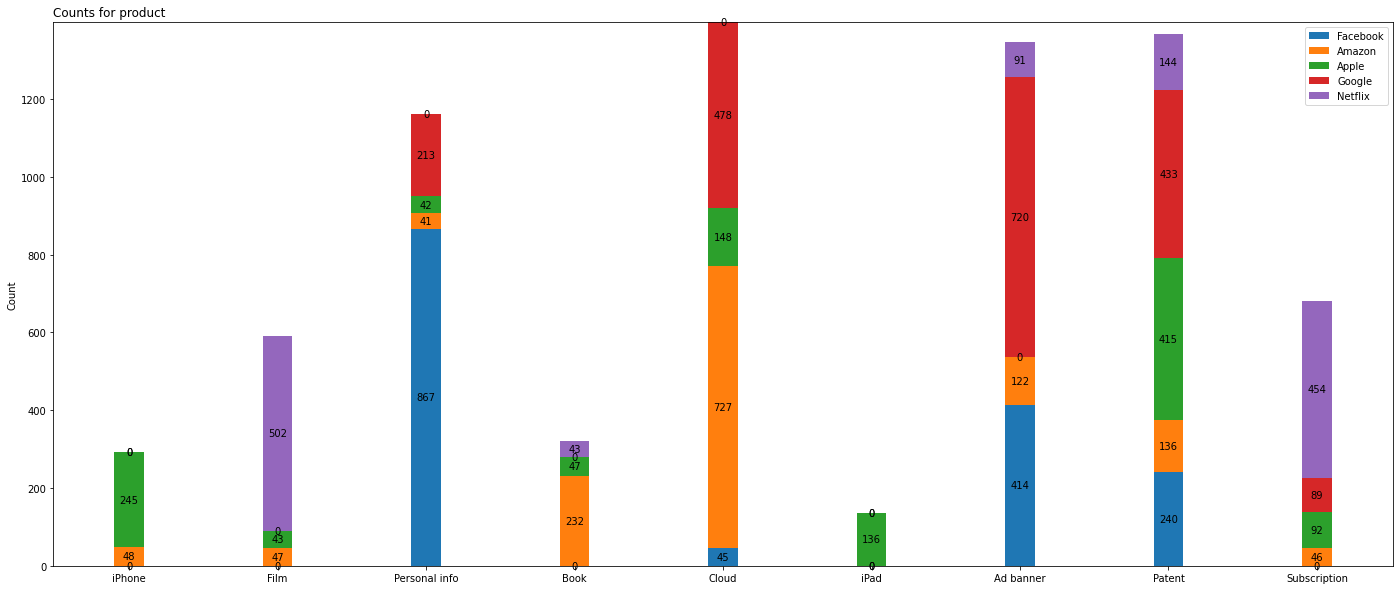

In [12]:
fig, ax = plt.subplots(figsize=(24, 10))
ax.set_ylabel('Count')
ax.set_title('Counts for product', loc='left')

sum_filials = [0] * len(products)

for filial in filials:
    filial_counts = [summary_count[filial][product] for product in products]
    bar = ax.bar(products, filial_counts, 0.2, bottom=sum_filials, label=filial)
    ax.bar_label(bar, label_type='center')
    sum_filials = [curr + add for (curr, add) in zip(sum_filials, filial_counts)]

ax.legend()
plt.show()

In [13]:
sum_products = [0] * len(filials)

for product in products:
    product_counts = [summary_count[filial][product] for filial in filials]
    bar = ax.bar(filials, product_counts, 0.2, bottom=sum_products, label=product)
    ax.bar_label(bar, label_type='center')
    sum_products = [curr + add for (curr, add) in zip(sum_products, product_counts)]

ax.legend()
plt.show()

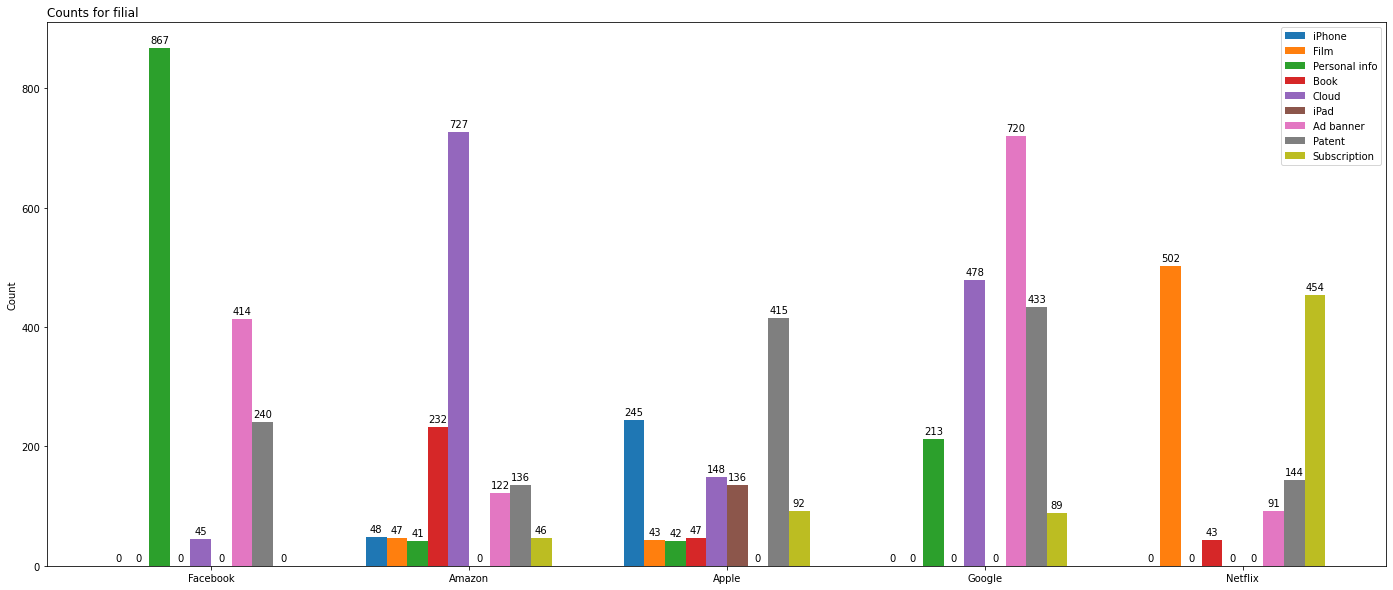

In [14]:
width = 0.08
x = np.arange(len(filials))
dx = (np.arange(len(products)) - (len(products) / 2)) * width

fig, ax = plt.subplots(figsize=(24, 10))
ax.set_ylabel('Count')
ax.set_title('Counts for filial', loc='left')
ax.set_xticks(x)
ax.set_xticklabels(filials)

for (product, d) in zip(products, dx):
    product_counts = [summary_count[filial][product] for filial in filials]
    bar = ax.bar(x + d, product_counts, width, label=product)
    ax.bar_label(bar, padding=3)

ax.legend()
plt.show()

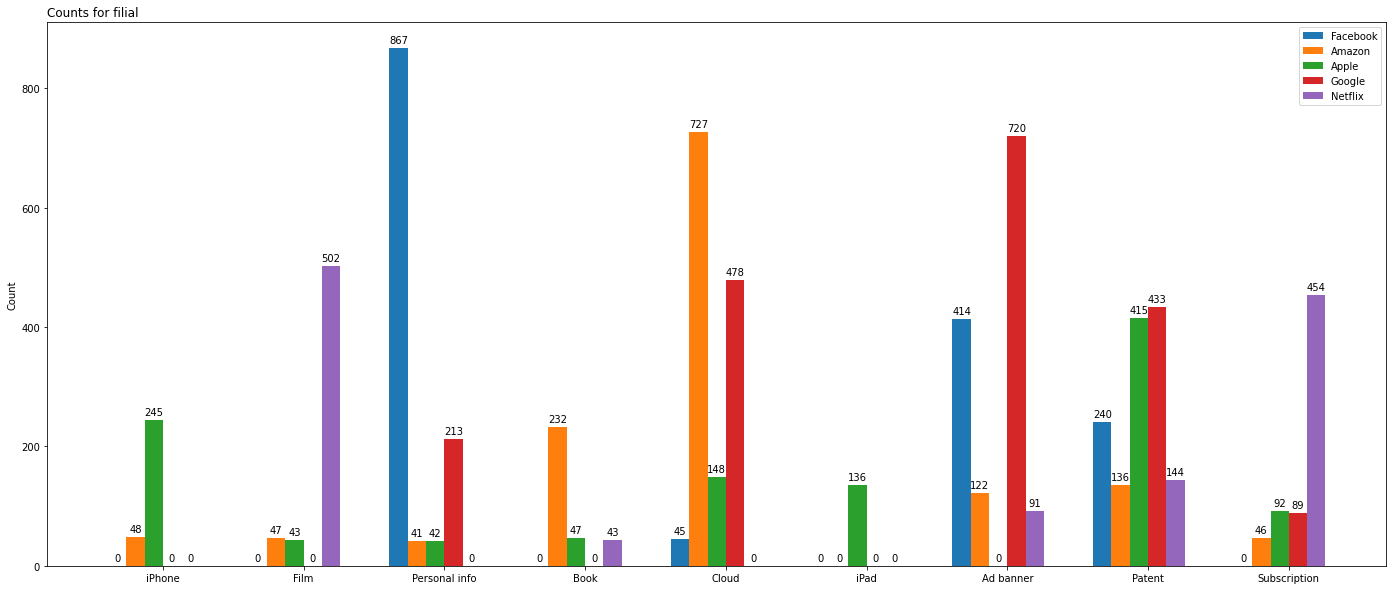

In [15]:
width = 0.13
x = np.arange(len(products))
dx = (np.arange(len(filials)) - (len(filials) / 2)) * width

fig, ax = plt.subplots(figsize=(24, 10))
ax.set_ylabel('Count')
ax.set_title('Counts for filial', loc='left')
ax.set_xticks(x)
ax.set_xticklabels(products)

for (filial, d) in zip(filials, dx):
    filial_counts = [summary_count[filial][product] for product in products]
    bar = ax.bar(x + d, filial_counts, width, label=filial)
    ax.bar_label(bar, padding=3)

ax.legend()